# Making predictions with Logistic Regression Model

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay






········


In [2]:
#1.Create a query or queries to extract the information you think may be relevant for building the prediction model. 
#It should include some film features and some rental features. Use the data from 2005.
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
select i.store_id, r.rental_date, f.film_id, f.title, f.description, f.length, p.amount from rental as r
right join inventory as i
on r.inventory_id = i.inventory_id
left join film as f
on i.film_id = f.film_id
left join payment as p 
on r.rental_id = p.rental_id
where YEAR(r.rental_date)=2005
;
'''

data = pd.read_sql_query(query, engine)
data


,store_id,rental_date,film_id,title,description,length,amount
0,1,2005-07-08 19:03:15,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,0.99
1,1,2005-08-02 20:13:10,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,3.99
2,1,2005-08-21 21:27:43,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,3.99
3,1,2005-05-30 20:21:07,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,1.99
4,1,2005-06-17 20:24:00,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,0.99
...,...,...,...,...,...,...,...
15857,2,2005-05-29 03:49:03,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,4.99
15858,2,2005-06-15 21:50:32,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,4.99
15859,2,2005-07-12 13:24:47,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,9.99
15860,2,2005-07-31 07:32:21,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,4.99


In [3]:
#2.Create a query to get the total amount of rentals in June for each film.
query = '''
select count(f.film_id) as 'amount_rentals', f.film_id, f.title from rental as r
left join inventory as i
on r.inventory_id = i.inventory_id
left join film as f
on i.film_id = f.film_id
where MONTH(r.rental_date)=6 AND YEAR(r.rental_date)=2005 
group by f.film_id
order by amount_rentals DESC;
'''
rental_6 = pd.read_sql_query(query, engine)
rental_6



,amount_rentals,film_id,title
0,7,891,TIMBERLAND SKY
1,6,625,NONE SPIKING
2,6,103,BUCKET BROTHERHOOD
3,6,738,ROCKETEER MOTHER
4,6,789,SHOCK CABIN
...,...,...,...
895,1,601,MOULIN WAKE
896,1,519,LIBERTY MAGNIFICENT
897,1,47,BABY HALL
898,1,248,DOZEN LION


In [4]:
#3.Create a query to get the total amount of rentals in July for each film.

query = '''
select count(f.film_id) as 'amount_rentals', f.film_id, f.title from rental as r
left join inventory as i
on r.inventory_id = i.inventory_id
left join film as f
on i.film_id = f.film_id
where MONTH(r.rental_date)=7 AND YEAR(r.rental_date)=2005 
group by f.film_id
order by amount_rentals DESC;
'''
rental_7 = pd.read_sql_query(query, engine)
rental_7

,amount_rentals,film_id,title
0,16,767,SCALAWAG DUCK
1,15,378,GREATEST NORTH
2,15,697,PRIMARY GLASS
3,14,531,LOSE INCH
4,14,403,HARRY IDAHO
...,...,...,...
953,2,569,MENAGERIE RUSHMORE
954,2,400,HARDLY ROBBERS
955,1,102,BUBBLE GROSSE
956,1,411,HEAVENLY GUN


In [5]:
#4.Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger than in June.
#Your objective will be to predict this new column.


rental_6_7=pd.merge(left = rental_6, # LEFT TABLE
                                 right = rental_7, # RIGHT TABLE
                                 how = 'right', # TYPE OF JOIN
                                 left_on = "film_id", # COMMON COLUMN IN LEFT TABLE
                                 right_on= "film_id") # COMMON COLUMN IN RIGTH TABLE

#rental_6_7.rename(columns={'amount_retnals_x':'amount_rentals_june','amount_retnals_y':'amount_rentals_july'})
rental_6_7

,amount_rentals_x,film_id,title_x,amount_rentals_y,title_y
0,6.0,767,SCALAWAG DUCK,16,SCALAWAG DUCK
1,4.0,378,GREATEST NORTH,15,GREATEST NORTH
2,4.0,697,PRIMARY GLASS,15,PRIMARY GLASS
3,3.0,531,LOSE INCH,14,LOSE INCH
4,5.0,403,HARRY IDAHO,14,HARRY IDAHO
...,...,...,...,...,...
953,1.0,569,MENAGERIE RUSHMORE,2,MENAGERIE RUSHMORE
954,NaN,400,NaN,2,HARDLY ROBBERS
955,1.0,102,BUBBLE GROSSE,1,BUBBLE GROSSE
956,1.0,411,HEAVENLY GUN,1,HEAVENLY GUN


In [6]:
#Cleaning data
#Replacing missing values
rental_6_7=rental_6_7.drop('title_x', axis=1)
rental_6_7=rental_6_7.fillna(0)
rental_6_7.isna().sum()

amount_rentals_x    0
film_id             0
amount_rentals_y    0
title_y             0
dtype: int64

In [7]:
#Creating a new column containing 'yes', 'no'

def amount_films_comparison(x,y):
    if y > x:
        return 'Yes'
    else:
        return 'No'
    
new_column=list(map(amount_films_comparison, rental_6_7['amount_rentals_x'],rental_6_7['amount_rentals_y']))

In [8]:
rental_6_7['high_rental_july']= new_column

In [9]:
#5.Read the data into a Pandas dataframe.
rental_6_7


,amount_rentals_x,film_id,amount_rentals_y,title_y,high_rental_july
0,6.0,767,16,SCALAWAG DUCK,Yes
1,4.0,378,15,GREATEST NORTH,Yes
2,4.0,697,15,PRIMARY GLASS,Yes
3,3.0,531,14,LOSE INCH,Yes
4,5.0,403,14,HARRY IDAHO,Yes
...,...,...,...,...,...
953,1.0,569,2,MENAGERIE RUSHMORE,Yes
954,0.0,400,2,HARDLY ROBBERS,Yes
955,1.0,102,1,BUBBLE GROSSE,No
956,1.0,411,1,HEAVENLY GUN,No


In [10]:
rental_6_7['high_rental_july'].value_counts()

Yes    952
No       6
Name: high_rental_july, dtype: int64

In [11]:
data2=pd.merge(left = rental_6_7, # LEFT TABLE
                                 right = data, # RIGHT TABLE
                                 how = 'right', # TYPE OF JOIN
                                 left_on = "film_id", # COMMON COLUMN IN LEFT TABLE
                                 right_on= "film_id") # COMMON COLUMN IN RIGTH TABLE



In [12]:
data2

,amount_rentals_x,film_id,amount_rentals_y,title_y,high_rental_july,store_id,rental_date,title,description,length,amount
0,3.0,1,9,ACADEMY DINOSAUR,Yes,1,2005-07-08 19:03:15,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,0.99
1,3.0,1,9,ACADEMY DINOSAUR,Yes,1,2005-08-02 20:13:10,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,3.99
2,3.0,1,9,ACADEMY DINOSAUR,Yes,1,2005-08-21 21:27:43,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,3.99
3,3.0,1,9,ACADEMY DINOSAUR,Yes,1,2005-05-30 20:21:07,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,1.99
4,3.0,1,9,ACADEMY DINOSAUR,Yes,1,2005-06-17 20:24:00,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,0.99
...,...,...,...,...,...,...,...,...,...,...,...
15857,5.0,1000,12,ZORRO ARK,Yes,2,2005-05-29 03:49:03,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,4.99
15858,5.0,1000,12,ZORRO ARK,Yes,2,2005-06-15 21:50:32,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,4.99
15859,5.0,1000,12,ZORRO ARK,Yes,2,2005-07-12 13:24:47,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,9.99
15860,5.0,1000,12,ZORRO ARK,Yes,2,2005-07-31 07:32:21,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,50,4.99


<AxesSubplot:>

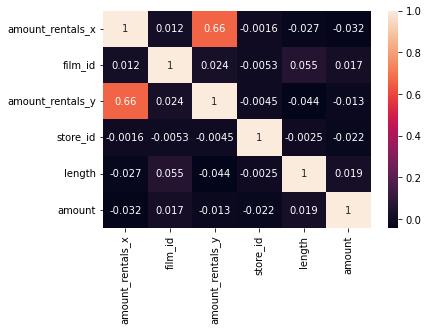

In [13]:
#Correlation between features
corr_matrix=data2.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)


In [14]:
pd.crosstab(data2['length'],data2['amount_rentals_x'])



amount_rentals_x,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
length,,,,,,,,
46,0,0,26,22,23,31,0,0
47,14,14,10,25,17,0,29,0
48,24,38,27,40,0,57,0,0
49,0,15,30,24,0,0,0,0
50,0,12,35,29,21,31,0,0
...,...,...,...,...,...,...,...,...
181,0,52,27,30,42,0,0,0
182,0,32,22,14,0,0,0,0
183,0,13,0,0,0,31,32,0


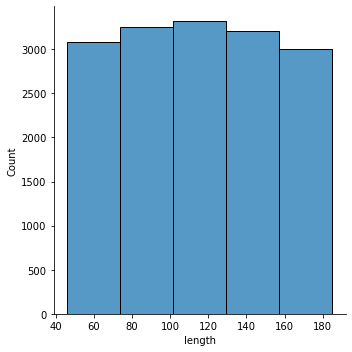

In [15]:
sns.displot(x='length',data=data2, bins=5)


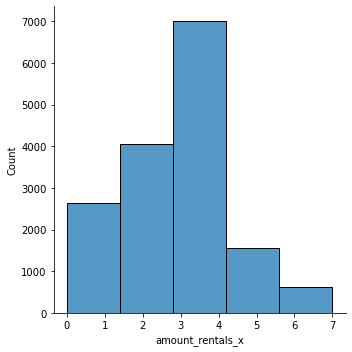

In [16]:
sns.displot(x='amount_rentals_x',data=data2, bins=5)



In [17]:
#6.Analyze extracted features and transform them. You may need to encode some categorical variables or scale numerical variables.
#X-y split

X=data2.loc[:,['amount_rentals_x', 'length', 'amount']]
y=data2['high_rental_july']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

#Scaling variables with StandardScaler

transformer = StandardScaler().fit(X_train) 

X_train_normalized = transformer.transform(X_train)
X_test_normalized  = transformer.transform(X_test)

X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_norm  = pd.DataFrame(X_test_normalized, columns=X_test.columns)


#The selected data doesn't have categorical features. Therefore, there's no need to apply OHE

In [18]:
X_train_norm

,amount_rentals_x,length,amount
0,-1.334437,1.448667,-0.521412
1,0.807674,-0.296208,-1.366016
2,0.093637,0.526376,-0.943714
3,-0.620400,0.900278,-1.366016
4,0.093637,1.049838,-0.099111
...,...,...,...
12684,0.093637,-0.744890,-0.099111
12685,-0.620400,0.277108,0.745493
12686,-2.048473,-0.395915,1.167795
12687,-1.334437,-0.894451,2.012398


In [19]:
#7.Create a logistic regression model to predict this new column from the cleaned data.
log_reg=LogisticRegression(random_state=11,solver='lbfgs',max_iter=1000).fit(X_train_norm, y_train)

y_test_pred = log_reg.predict(X_test_norm)

print(y_test_pred)

['Yes' 'Yes' 'Yes' ... 'Yes' 'Yes' 'Yes']


In [20]:
#8.Evaluate the results.

print(accuracy_score(y_test,y_test_pred))

0.9974787267570123


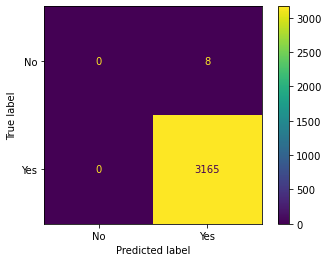

In [21]:
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels=log_reg.classes_)
disp.plot()
plt.show()

As the dataset has 952 values for 'Yes' and just 6 for 'No', the model predicted all 'Yes'.
There's a problem of class imbalance.